In [1]:
from scipy.misc import comb
import math
def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    # phan phoi nhi thuc
    probs = [comb(n_classifier, k) *
            error**k *
            (1 - error)**(n_classifier-k)
            for k in range(k_start, n_classifier + 1)]
    return sum(probs)
ensemble_error(n_classifier=11, error=0.25)

0.034327507019042969

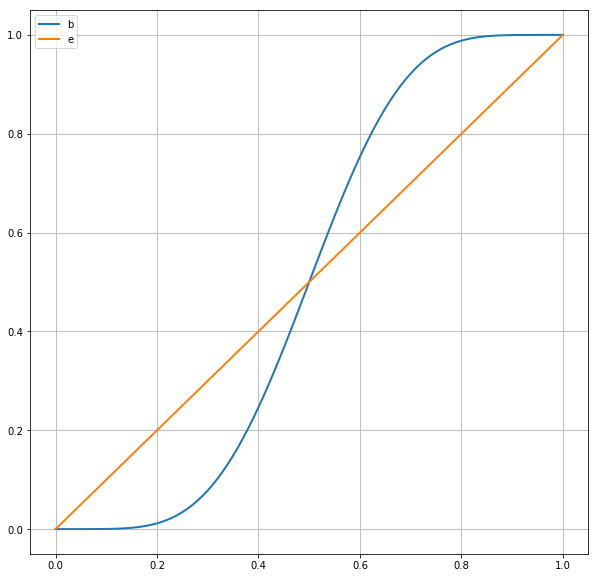

In [2]:
import numpy as np
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
             for error in error_range]
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,10))
plt.plot(error_range, ens_errors,
        label="Ensemble Error",
        linewidth=2)
plt.plot(error_range, error_range,
        label="Ensemble Error",
        linewidth=2)
plt.legend("best")
plt.grid()
plt.show()

In [3]:
ex = np.array([[0.9, 0.1],
              [0.8, 0.2],
              [0.6, 0.4]])
np.argmax(np.average(ex, axis=0, weights=[0.2, 0.2, 0.4]))

0

In [24]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator

class MajorityVoteClassifier(BaseEstimator,
                            ClassifierMixin):
    """ A majority vote ensemble classifier
    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
    Different classifiers for the ensemble
    vote : str, {'classlabel', 'probability'}
    Default: 'classlabel'
    If 'classlabel' the prediction is based on
    the argmax of class labels. Else if
    'probability', the argmax of the sum of
    probabilities is used to predict the class label
    (recommended for calibrated classifiers).
    weights : array-like, shape = [n_classifiers]
    Optional, default: None
    If a list of `int` or `float` values are
    [ 206 ]Chapter 7
    provided, the classifiers are weighted by
    importance; Uses uniform weights if `weights=None`.
    """
    def __init__(self, classifiers,
                vote="classlabel", weights=None):
        self.classifiers = classifiers
        self.name_classifiers = {key: value for
                                key, value in 
                                _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def fit(self, X, y):
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X,
                                       self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote == "probability":
            maj_vote = np.argmax(self.predict_proba(X),
                                axis=1)
        else:
            predictions = np.asarray([clf.predict(X)
                                     for clf in
                                     self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x:
                                          np.argmax(np.bincount(x,
                                                                weights = self.weights)),
                                          axis=1,
                                          arr=predictions)
            maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
        
        
    def predict_proba(self, X):
        probas = np.array([clf.predict_proba(X) for
                          clf in self.classifiers_])
        avg_probs = np.average(probas, axis=0,
                             weights=self.weights)
        return avg_probs
    
    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier,
                         self).get_params(deep=False)
        else:
            out = self.name_classifiers.copy()
            for name, step in \
                six.iteritems(self.name_classifiers):
                    for key, value in six.iteritems(step.get_params(deep=True)):
                        out['%s__%s' % (name, key)] = value
            return out

In [25]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [26]:
X_train, X_test, y_train, y_test = \
            train_test_split(X, y, 
                            test_size=0.5,
                            random_state=1)

In [27]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np
clf1 = LogisticRegression(penalty="l2",
                         C=0.001,
                         random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1,
                             criterion="entropy",
                             random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                           p=2, metric="minkowski")
pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe2 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf2]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"% (scores.mean(),
                                              scores.std(), label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


In [28]:
my_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, my_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                            X=X_train,
                            y=y_train,
                            cv=10,
                            scoring="f1")
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"% (scores.mean(),
                                               scores.std(), label))

Accuracy: 0.79 (+/- 0.30) [Logistic Regression]
Accuracy: 0.86 (+/- 0.30) [Decision Tree]
Accuracy: 0.91 (+/- 0.14) [KNN]
Accuracy: 0.86 (+/- 0.30) [Majority Voting]


/home/jeovach/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jeovach/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


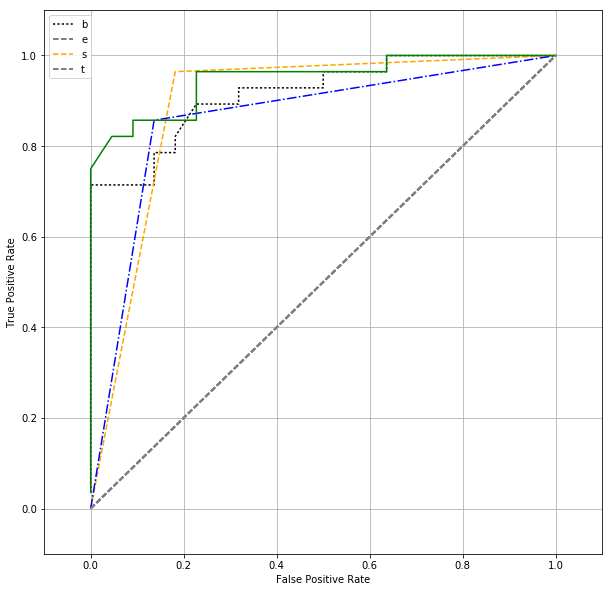

In [29]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
plt.figure(figsize=(10,10))
for clf, label, clr, ls in zip(all_clf,
                              clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresolds = roc_curve(y_true=y_test,
                                   y_score = y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
            color=clr,
            linestyle=ls,
            label='%s (auc = %0.2f)' % (label, roc_auc))
    plt.legend("best")
    plt.plot([0,1],[0,1],
            linestyle='--',
             color='gray',
             linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show() 

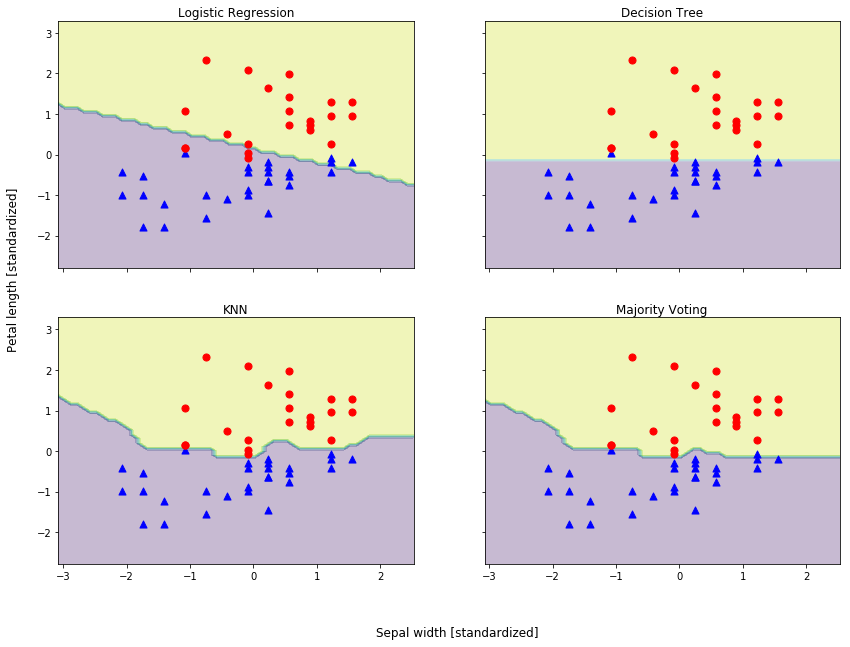

In [30]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                    np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex="col",
                        sharey="row",
                        figsize=(14,10))
for idx, clf, tt in zip(product([0,1], [0,1]),
                       all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                 X_train_std[y_train==0, 1],
                                 c="blue",
                                 marker="^",
                                 s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                 X_train_std[y_train==1, 1],
                                 c="red",
                                 marker="o",
                                 s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5,
         s='Sepal width [standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5,
         s='Petal length [standardized]',
         ha='center', va='center',
         fontsize=12, rotation=90)
plt.show()

In [31]:
my_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_split': 1e-07,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_

# Dieu chinh cac tham so cua classifier = GridSearchCV

In [36]:
from sklearn.grid_search import GridSearchCV
params = {"decisiontreeclassifier__max_depth": [1, 2],
          "pipeline-1__clf__C": [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=my_clf,
                    param_grid=params,
                    cv=10,
                    scoring="roc_auc")
grid.fit(X_train, y_train)
for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f+/-%0.2f %r"
          % (mean_score, scores.std() / 2, params))

0.967+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


# Bagging – building an ensemble of classifiers from bootstrap samples

In [39]:
import pandas as pd
df_wine = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data",
    header=None)
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash',
                   'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine["Class label"].values
X = df_wine[["Alcohol", "Hue"]].values

In [42]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test =train_test_split(X, y,
                                                   test_size=0.40,
                                                   random_state=1)

In [45]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion="entropy",
                             max_depth=None)
bag = BaggingClassifier(base_estimator=tree,
                       n_estimators=500,
                       max_samples=1.0,
                       max_features=1.0,
                       bootstrap=True,
                       bootstrap_features=False,
                       n_jobs=1,
                       random_state=1)

In [46]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

Decision tree train/test accuracies 1.000/0.854


In [47]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print("%.3f / %.3f" %(bag_train, bag_test))

1.000 / 0.896


 co the thay la cai nay giam overfit rat tot

# Leveraging weak learners via adaptive boosting

In [53]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree,
                        n_estimators=500,
                        learning_rate=0.1,
                        random_state=0)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
ada = ada.fit(X_train, y_train)
train_pred = ada.predict(X_train)
test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, train_pred)
ada_test = accuracy_score(y_test, test_pred)
print('%.3f/%.3f'
      % (tree_train, tree_test))
print('%.3f/%.3f'
      % (ada_train, ada_test))

0.845/0.854
1.000/0.875
